# Waste Classification Model Evaluation
**Model**: EfficientNet-B0 (Baseline Configuration)  
**Test Accuracy**: 95.42%

This notebook provides interactive evaluation of the trained waste classifier:
1. **Quantitative Analysis**: Confusion matrix and per-class metrics
2. **Qualitative Analysis**: GradCAM heatmaps to visualize model attention

For batch evaluation of multiple models, use:
```bash
python evaluate.py --all
```

In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report, confusion_matrix

# Setup paths
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from model import WasteClassifier
from utils.gradcam import GradCAM

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Load Model & Data

In [ ]:
# Initialize Model
model = WasteClassifier(num_classes=9)

# Load Weights (Try V11 final, fallback to epoch 30)
weights_path = os.path.join(parent_dir, 'weights', 'best_waste_model.pth')
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print(f"Loaded weights from: {weights_path}")
else:
    print("WARNING: Weights not found!")

model.to(device)
model.eval();

Loaded weights from: d:\Projects\MachineLearning\waste_classification\pretrained\v11\best_waste_model_final.pth


In [3]:
# Data Transforms (Validation/Test Standard)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Load Dataset
data_dir = os.path.join(parent_dir, 'dataset')
if not os.path.exists(os.path.join(data_dir, 'Metal')):
    # Check for unzipped folder structure
    if os.path.exists(os.path.join(data_dir, 'RealWaste', 'Metal')):
        data_dir = os.path.join(data_dir, 'RealWaste')

dataset = ImageFolder(data_dir, transform=transform)
classes = dataset.classes
print(f"Classes: {classes}")

# REPLICATE TRAINING SPLIT LOGIC
# Stratified Split (80% Train, 10% Val, 10% Test)
from sklearn.model_selection import train_test_split

# Get indices per class
class_indices = {i: [] for i in range(len(dataset.classes))}
for idx, (_, label) in enumerate(dataset.samples):
    class_indices[label].append(idx)

test_indices = []

# Replicate the split logic with random_state=42
for label, indices in class_indices.items():
    # First split: 80% Train, 20% Temp
    train_idx, temp_idx = train_test_split(
        indices, train_size=0.8, random_state=42, stratify=[label]*len(indices)
    )
    # Second split: Temp -> 50% Val, 50% Test
    val_idx, test_idx = train_test_split(
        temp_idx, train_size=0.5, random_state=42, stratify=[label]*len(temp_idx)
    )
    test_indices.extend(test_idx)

print(f"Total images: {len(dataset)}")
print(f"Test set sizes: {len(test_indices)}")

eval_subset = Subset(dataset, test_indices)
dataloader = DataLoader(eval_subset, batch_size=32, shuffle=False)
print(f"Evaluating on {len(eval_subset)} samples (Dedicated Test Set).")

## 2. Quantitative Evaluation

In [4]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

Evaluating: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s]


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       1.00      1.00      1.00       131
      Food Organics       1.00      1.00      1.00        57
              Glass       0.98      1.00      0.99       130
              Metal       0.99      0.99      0.99       162
Miscellaneous Trash       0.96      1.00      0.98        69
              Paper       1.00      0.99      1.00       139
            Plastic       0.99      0.97      0.98       195
      Textile Trash       0.98      1.00      0.99        43
         Vegetation       1.00      1.00      1.00        74

           accuracy                           0.99      1000
          macro avg       0.99      0.99      0.99      1000
       weighted avg       0.99      0.99      0.99      1000



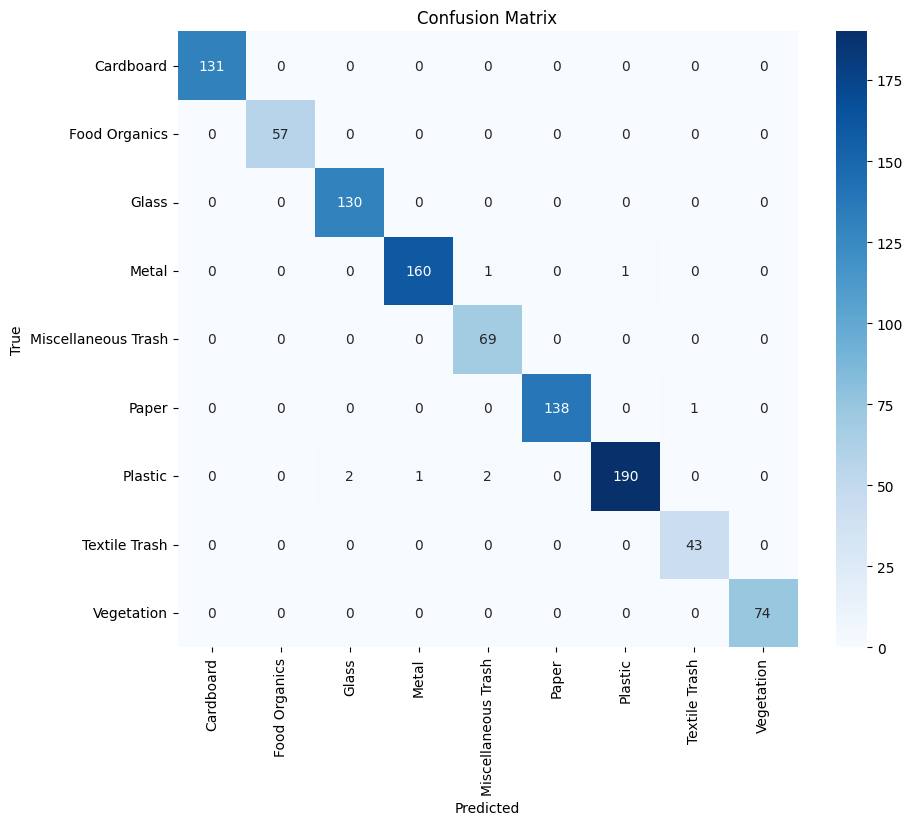

In [5]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 3. Qualitative Analysis (GradCAM)
We visualize the model's focus using Gradient-weighted Class Activation Mapping (GradCAM).

d:\Projects\MachineLearning\waste_classification\venv\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


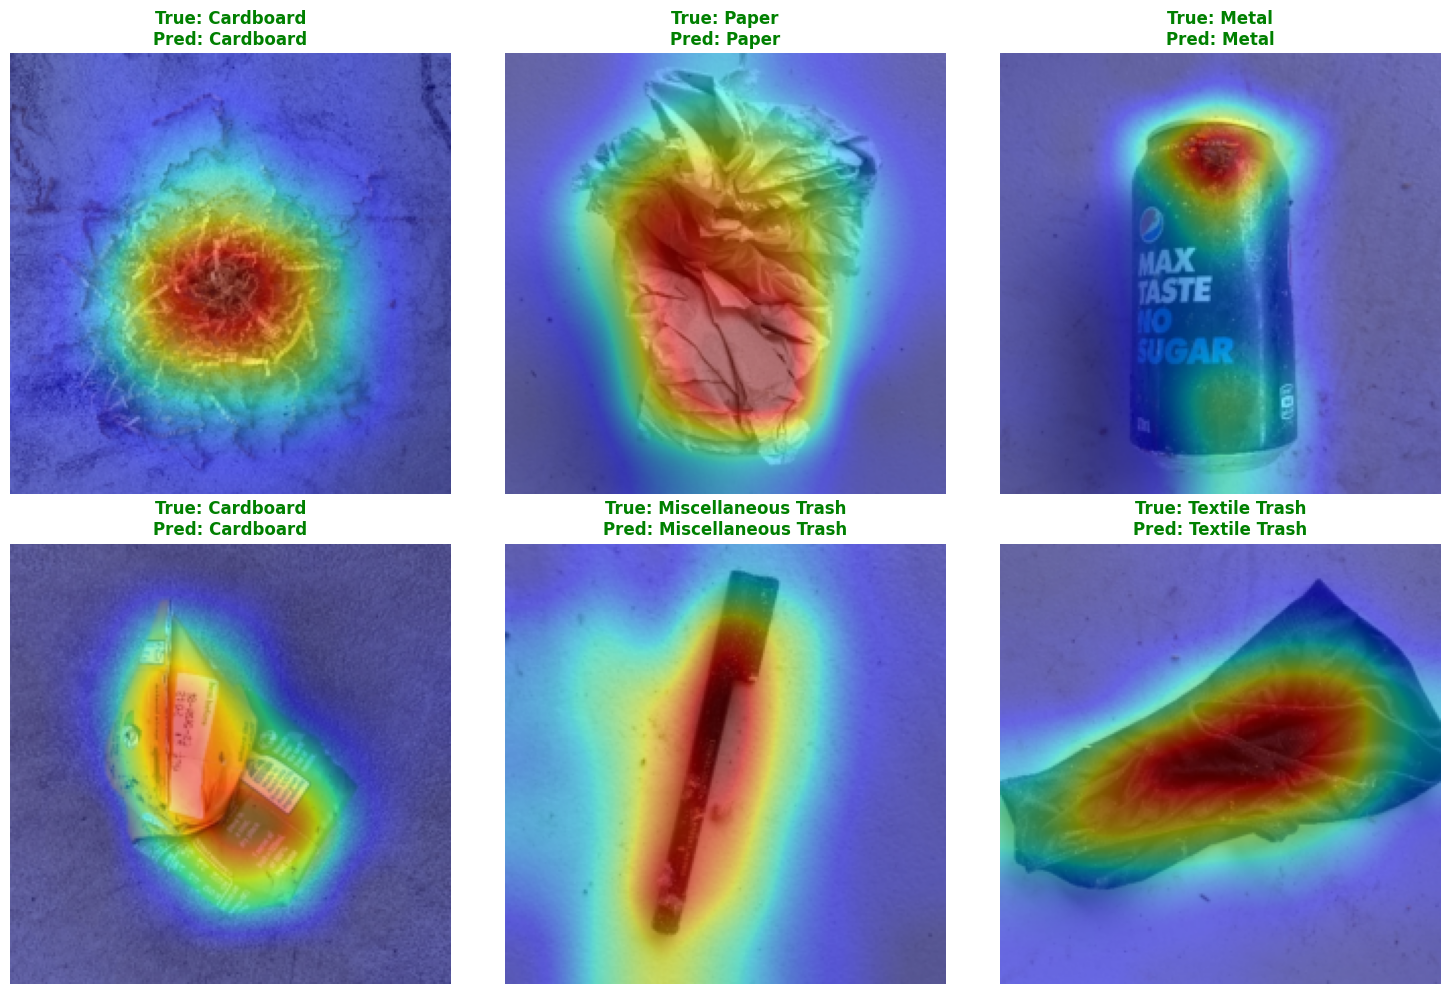

In [6]:
def denormalize(tensor):
    tensor = tensor.clone().detach().cpu()
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).numpy()

# Initialize GradCAM
# EfficientNet-B0's last convolutional feature map is in features[-1]
target_layer = model.backbone.features[-1]
grad_cam = GradCAM(model, target_layer)

# Select 6 random samples
sample_indices = random.sample(range(len(eval_subset)), 6)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    image, label = eval_subset[idx]
    
    # Prepare input
    input_tensor = image.unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = output.argmax(dim=1).item()
        
    # Generate Heatmap
    cam = grad_cam.generate_cam(input_tensor)
    
    # Visualization
    img_np = denormalize(image)
    img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
    overlay = grad_cam.overlay_heatmap(img_pil, cam, alpha=0.5)
    
    ax = axes[i]
    ax.imshow(overlay)
    ax.axis('off')
    
    color = 'green' if pred_idx == label else 'red'
    ax.set_title(f"True: {classes[label]}\nPred: {classes[pred_idx]}", color=color, fontweight='bold')

plt.tight_layout()
plt.show()